In [1]:
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(1, module_path)
    
print sys.path
from collections import OrderedDict

import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

from sklearn.isotonic import IsotonicRegression
from calmap import plot_calibration_map
from betacal import BetaCalibration
from utils.utils import MyLogisticRegression

from utils.visualisations import plot_reliability_diagram

['', '/home/maikel/git/uob/betacal', '/home/maikel/git/uob/betacal/venv/lib/python2.7/site-packages', '', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/maikel/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/home/maikel/git/GPflow', '/usr/local/lib/python2.7/dist-packages/openml-0.3.0-py2.7.egg', '/usr/local/lib/python2.7/dist-packages/xmltodict-0.10.2-py2.7.egg', '/usr/local/lib/python2.7/dist-packages/liac_arff-2.1.1.dev0-py2.7.egg', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/lib/pymodules/python2.7', '/usr/lib/python2.7/dist-packages/ubuntu-sso-client', '/usr/lib/python2.7/dist-packages/wx-2.8-gtk2-unicode', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/maikel/.ipython']


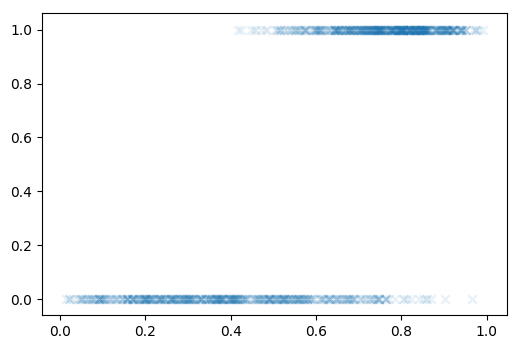

In [2]:
n_samples = 1000
prior0 = 0.5
prior1 = 1-prior0
a0 = 2.0
b0 = 3.0
a1 = 10.0
b1 = 3.0
pos_x = np.random.beta(a0, b0, int(n_samples*prior0))
neg_x = np.random.beta(a1, b1, int(n_samples*prior1))

x = np.hstack((pos_x, neg_x))
y = np.hstack((np.zeros(int(n_samples*prior0)), np.ones(int(n_samples*prior1))))

plt.scatter(x, y, marker='x', alpha=0.1)

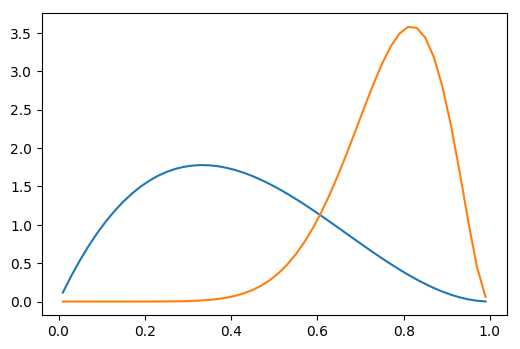

In [3]:
s = np.linspace(0.01, 0.99, 50)

plt.plot(s, beta.pdf(s, a0, b0))
plt.plot(s, beta.pdf(s, a1, b1))

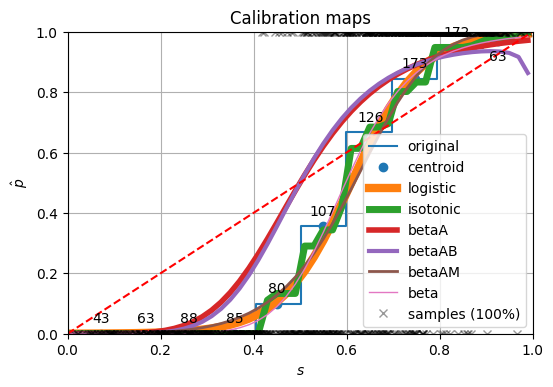

In [4]:
tiny = np.finfo(np.float).eps

lr = MyLogisticRegression(C=99999999999)
iso = IsotonicRegression(out_of_bounds='clip')
bca = BetaCalibration(parameters="a")
bcab = BetaCalibration(parameters="ab")
bcam = BetaCalibration(parameters="am")
bc = BetaCalibration(parameters="abm")

beta_calibrators = OrderedDict([('betaA', bca),
                                ('betaAB', bcab),
                                ('betaAM', bcam),
                                ('beta', bc),
                                ])

calibrators = OrderedDict([('logistic', lr),
                           ('isotonic', iso)]
                         )
calibrators.update(beta_calibrators)

# Train calibrators
calib_map = OrderedDict()
for key in calibrators.keys():
    calibrators[key].fit(x, y)
    # Generate calibration map
    calib_map[key] = calibrators[key].predict(s)

fig = plt.figure('rel_map')
fig = plot_reliability_diagram(x, y, s,
                         calib_map.values(),
                         legend_set=calibrators.keys(),
                         alpha=tiny, scatter_prop=1.0,
                         title='Calibration maps',
                         fig=fig)

In [5]:
a = a1 - a0
b = b0 - b1
# FIXME compute m
m = np.nan
print('Original values :\t a = {:0.2f}, b = {:0.2f}, m = {:0.2f}'.format(a,b,m))
for key, calibrator in beta_calibrators.items():
    print('Estimated ({}) :\t a = {:0.2f}, b = {:0.2f}, m = {:0.2f}'.format(key, *calibrator.calibrator_.map_))

Original values :	 a = 8.00, b = 0.00, m = nan
Estimated (betaA) :	 a = 5.18, b = 5.18, m = 0.50
Estimated (betaAB) :	 a = 6.25, b = -0.62, m = 0.50
Estimated (betaAM) :	 a = 2.83, b = 2.83, m = 0.62
Estimated (beta) :	 a = 8.17, b = 0.00, m = 0.60
